In [1]:
import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.distributions import Categorical
from collections import deque
import torch.optim as optim
import copy
import time
from gym import wrappers
%matplotlib inline

In [2]:
env = gym.make('Acrobot-v1')
action_size = env.action_space.n
action_size

3

In [3]:
action = env.action_space.sample()
action

0

In [4]:
state_low = env.observation_space.low
state_high = env.observation_space.high
state_size = len(state_high)
state_size

6

In [5]:
print(state_low, state_high)

[ -1.        -1.        -1.        -1.       -12.566371 -28.274334] [ 1.        1.        1.        1.       12.566371 28.274334]


In [6]:
class Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Model, self).__init__()
        
        self.seed = torch.manual_seed(7)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        
#         self.dropout(state)
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
#         self.dropout(state)
        action_prob = F.softmax(self.fc3(state), dim=1)
        
        m = Categorical(action_prob)
        action = m.sample()
        
        return action.item(), m.log_prob(action)
        

In [7]:
model = Model(state_size, action_size)
model

Model(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [58]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [75]:
def REINFORCE():
    n_episode = 5000
    scores_deque = deque(maxlen=100)
    scores = []
    gamma = 1.0
    for i_episode in range(n_episode+1):
        state = env.reset()
        done = False
        action_log_prob = []
        all_rewards = []
        while not done:
#             state_dis = discretize_state(state)
            action, log_prob = model(state)
            action_log_prob.append(log_prob)
            state, reward, done, _ = env.step(action)
            all_rewards.append(reward)
            if done:
                break
                
        scores.append(sum(all_rewards))
        scores_deque.append(sum(all_rewards))
                
        discounts = [gamma**i  for i in range(len(all_rewards))]
        total_rewards = sum([a*b for a,b in zip(all_rewards, discounts)])
        policy_loss = []
        
        for log_prob in action_log_prob:
            policy_loss.append(-log_prob*total_rewards)
            
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        print('\rEpisode {} \tLoss {} '.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode%100==0:
            print('\rEpisode {} \tLoss {} '.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= -100.0 and i_episode>=100:
            print('\rEpisode {} \tLoss {} '.format(i_episode, np.mean(scores_deque)))
            torch.save(model.state_dict(), 'acrobot_checkpoint_1.pth')
            break
    return scores
        
            
        

In [363]:
scores = REINFORCE()

Episode 0 	Loss -500.0 
Episode 100 	Loss -225.03 3636363637 
Episode 200 	Loss -156.26 
Episode 300 	Loss -163.44 
Episode 381 	Loss -99.82  


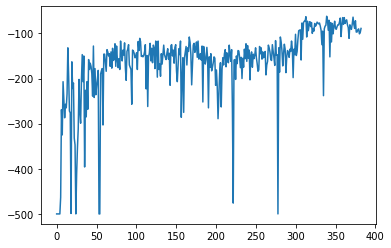

In [370]:
plt.plot(np.linspace(0, len(scores), num=len(scores)), scores)
plt.show()

In [396]:
state = env.reset()
done = False
score = 0
model.load_state_dict(torch.load('acrobot_checkpoint.pth'))
model.eval()
while not done:
#     time.sleep(0.01)
    env.render()
    action, _ = model(state)
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        break
        
print(score)

-71.0


In [12]:
class NEWModel(nn.Module):
    def __init__(self, state_size, action_size):
        super(NEWModel, self).__init__()
        
        self.seed = torch.manual_seed(7)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        
        self.dropout(state)
        state = F.relu(self.fc1(state))
        self.dropout(state)
        state = F.relu(self.fc2(state))
        self.dropout(state)
        action_prob = F.softmax(self.fc3(state), dim=1)
        
        m = Categorical(action_prob)
        action = m.sample()
        
        return action.item(), m.log_prob(action)
        

In [18]:
newModel = NEWModel(state_size, action_size)
newOptimizer = optim.Adam(newModel.parameters(), lr=0.01)
newModel

NEWModel(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [14]:
def NEWREINFORCE():
    n_episode = 5000
    scores_deque = deque(maxlen=100)
    scores = []
    gamma = 1.0
    for i_episode in range(n_episode+1):
        state = env.reset()
        done = False
        action_log_prob = []
        all_rewards = []
        while not done:
            action, log_prob = newModel(state)
            action_log_prob.append(log_prob)
            state, reward, done, _ = env.step(action)
            all_rewards.append(reward)
            if done:
                break
                
        scores.append(sum(all_rewards))
        scores_deque.append(sum(all_rewards))
                
        discounts = [gamma**i  for i in range(len(all_rewards))]
        total_rewards = sum([a*b for a,b in zip(all_rewards, discounts)])
        policy_loss = []
        
        for log_prob in action_log_prob:
            policy_loss.append(-log_prob*total_rewards)
            
        policy_loss = torch.cat(policy_loss).sum()
        
        newOptimizer.zero_grad()
        policy_loss.backward()
        newOptimizer.step()
        
        print('\rEpisode {} \tLoss {} '.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode%100==0:
            print('\rEpisode {} \tLoss {} '.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > -90.0:
            print('\rEpisode {} \tLoss {} '.format(i_episode, np.mean(scores_deque)))
            torch.save(newModel.state_dict(), 'NEWAcrobot_checkpoint.pth')
            break
    return scores
        

In [15]:
newScores = NEWREINFORCE()

Episode 0 	Loss -500.0 
Episode 100 	Loss -361.97 767676768  
Episode 200 	Loss -169.2  
Episode 300 	Loss -122.71 
Episode 400 	Loss -113.5  
Episode 500 	Loss -99.46  
Episode 600 	Loss -96.55  
Episode 700 	Loss -98.38 
Episode 787 	Loss -89.29 


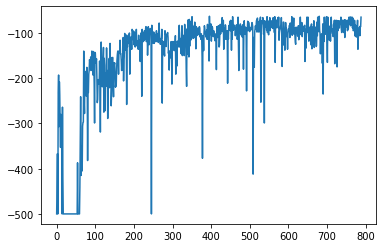

In [17]:
plt.plot(np.linspace(0, len(newScores), num=len(newScores)), newScores)
plt.show()

In [21]:
env.close()